# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
# import torch
from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.53685048.kevidu/ipykernel_459866/2601860326.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis.analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

In [5]:
# sns.color_palette("colorblind")
# print(sns.color_palette("colorblind").as_hex())

'Bitstream Vera Sans'

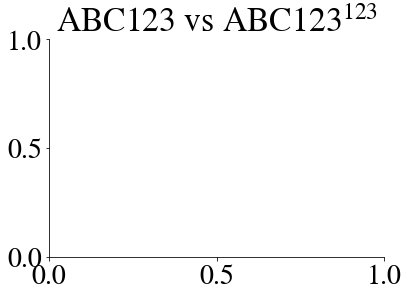

In [66]:
from mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [7]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s14.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
CONTEXT_TYPES = config["CONTEXT_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    CONTEXT_TYPES=CONTEXT_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [8]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
2024-04-04 16:21:29.577241: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'nump

{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s14.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 14, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': False, 'MAX_CONTEXTS': 600, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entit

In [9]:
# # Downloads yago_qec.json from wandb (if not already cached there)
# artifact, files = load_artifact_from_wandb(
#     f"{DATASET_NAME}-yago_qec", save_dir=Path(RAW_DATA_PATH).parent
# )
# artifact.name

In [10]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [11]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [12]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped


In [13]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [14]:
# qid_to_artifact_path = {
#     query_id: add_val_df_to_wandb(
#         yago_qec=yago_qec,
#         **DATASET_KWARGS,
#         QUERY_ID=query_id,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [15]:
# query_ids = list(
#     set(query_ids).difference(
#         [
#             # "http://yago-knowledge.org/resource/studentsCount",
#             # "http://schema.org/numberOfPages",
#             "http://yago-knowledge.org/resource/distanceFromEarth",
#             # "http://schema.org/numberOfEmployees",
#             # "http://schema.org/numberOfEpisodes",
#             # "http://schema.org/numberOfSeasons",
#             # "http://schema.org/humanDevelopmentIndex",
#             "http://schema.org/duns",
#             # "http://schema.org/duration",
#             "http://schema.org/unemploymentRate",
#             "http://yago-knowledge.org/resource/radialVelocity",
#             # "http://schema.org/populationNumber",
#             "http://yago-knowledge.org/resource/luminosity",
#             "http://yago-knowledge.org/resource/parallax",
#             "http://yago-knowledge.org/resource/length",
#             "http://schema.org/elevation",
#             # "http://yago-knowledge.org/resource/sportNumber",
#             "http://yago-knowledge.org/resource/mass",
#         ]
#         # [
#         #     "http://yago-knowledge.org/resource/studentsCount",
#         #     "http://schema.org/numberOfPages",
#         #     "http://yago-knowledge.org/resource/distanceFromEarth",
#         #     "http://schema.org/numberOfEmployees",
#         #     "http://schema.org/numberOfEpisodes",
#         #     "http://schema.org/numberOfSeasons",
#         #     "http://schema.org/humanDevelopmentIndex",
#         #     "http://schema.org/duns",
#         #     "http://schema.org/duration",
#         #     "http://schema.org/unemploymentRate",
#         #     "http://yago-knowledge.org/resource/radialVelocity",
#         #     "http://schema.org/populationNumber",
#         #     "http://yago-knowledge.org/resource/luminosity",
#         #     "http://yago-knowledge.org/resource/parallax",
#         #     "http://yago-knowledge.org/resource/length",
#         #     "http://schema.org/elevation",
#         #     "http://yago-knowledge.org/resource/sportNumber",
#         #     "http://yago-knowledge.org/resource/mass",
#         # ]
#     )
# )
# # qid_to_results_paths = {
# #     query_id: load_val_df_from_wandb(
# #         yago_qec=yago_qec,
# #         **DATASET_KWARGS,
# #         QUERY_ID=query_id,
# #         verbose=False,
# #         overwrite_df=True,
# #     )
# #     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
# #     for query_id in tqdm(query_ids)
# # }

In [16]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://yago-knowledge.org/resource/length",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://yago-knowledge.org/resource/length.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   contexts               400 non-null    object 
 5   persuasion_scores      400 non-null    object 
 6   persuasion_scores_kl   400 non-null    object 
 7   type                   400 non-null    object 
 8   susceptibility_score   400 non-null    float64
 9   sampled_mr             400 non-null    float64
 10  sampled_answergroups   400 non-null    object 
 11  sampled_outputs        400 non-null    object 
 12  entity_classes         400 non-null    object 
 13  query_type             400 non-null    

In [17]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

 19%|█▉        | 24/125 [01:09<05:07,  3.04s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv'


 35%|███▌      | 44/125 [02:05<04:12,  3.12s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv'


 52%|█████▏    | 65/125 [03:08<03:06,  3.10s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/14/models/EleutherAI/pythia-6.9b-deduped/results/val.csv'


100%|██████████| 125/125 [06:38<00:00,  3.18s/it]


In [18]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/motto', 'http://schema.org/url', 'http://schema.org/gtin'}


In [19]:
print(len(qid_to_val_df_per_qe))

122


In [20]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://yago-knowledge.org/resource/length"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,sampled_mr,sampled_answergroups,sampled_outputs,entity_classes,query_type,relevant_context_inds,model_id
320,http://yago-knowledge.org/resource/length,The length of {entity} is,"(Autopista AP-7,)",1109,"[Definitely, the length of A-5 is 1.709.\n, De...","[2.142348051071167, -0.7659506797790527, -0.55...","[1.595864002211141, 0.9642280804437224, 0.4379...",entities,0.552221,0.000000,"[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' 1.709.\nThe length of Autop', ' 114.74.\nTh...",{'http://schema.org/Organization': 0.038461538...,open,"[30, 31, 32, 33, 34, 35]",EleutherAI/pythia-6.9b-deduped
316,http://yago-knowledge.org/resource/length,The length of {entity} is,"(European route E201,)",173,"[Definitely, the length of A-5 is 1.709.\n, De...","[2.3357954025268555, -0.8057098388671875, -0.5...","[1.6375320028090443, 0.8046070813488382, 0.474...",entities,0.570314,0.333333,"[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' 1.709.\nThe length of European route', ' 11...",{'http://schema.org/Organization': 0.038461538...,open,"[156, 157, 158, 159, 160, 161]",EleutherAI/pythia-6.9b-deduped
332,http://yago-knowledge.org/resource/length,The length of {entity} is,"(Tōkaidō,)",514,"[Definitely, the length of A-5 is 1.709.\n, De...","[1.4311730861663818, -0.8153700828552246, -0.8...","[1.1681373640727841, 0.6256632470092949, 0.500...",entities,0.574471,0.000000,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' 1.709.\nThe length of Shink', ' about 1,500...",{'http://schema.org/Organization': 0.038461538...,open,"[522, 523, 524, 525, 526, 527]",EleutherAI/pythia-6.9b-deduped
331,http://yago-knowledge.org/resource/length,The length of {entity} is,"(Beijing–Kowloon railway,)",2311,"[Definitely, the length of A-5 is 1.709.\n, De...","[1.219339370727539, -0.6210336685180664, -0.72...","[1.0092580608834238, 0.8653156465592124, 0.443...",entities,0.591477,0.500000,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' 1.709.\nThe length of Beijing–', ' about 1,...",{'http://schema.org/Organization': 0.038461538...,open,"[48, 49, 50, 51, 52, 53]",EleutherAI/pythia-6.9b-deduped
334,http://yago-knowledge.org/resource/length,The length of {entity} is,"(Bundesstraße 106,)",40.7,"[Definitely, the length of A-5 is 1.709.\n, De...","[1.9171631336212158, -0.893639087677002, -0.62...","[1.4987784868982836, 0.9212905945681432, 0.458...",entities,0.602540,0.000000,"[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' 1.709.\nThe length of Bundesstra', ' 114.74...",{'http://schema.org/Organization': 0.038461538...,open,"[84, 85, 86, 87, 88, 89]",EleutherAI/pythia-6.9b-deduped


In [21]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [22]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
# FAKE_ENTITY_FREQ_THRESHOLD = (
#     0  # filter out any fake entities with frequency greater than this
# )
FAKE_ENTITY_FREQ_THRESHOLD = np.inf  # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 122/122 [00:00<00:00, 227.92it/s]


[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


### Comparison to MR (susceptibility)

In [23]:
# Open queries
qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
print(len(qid_to_dfs_with_mr))

122


/cluster/home/kevidu/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


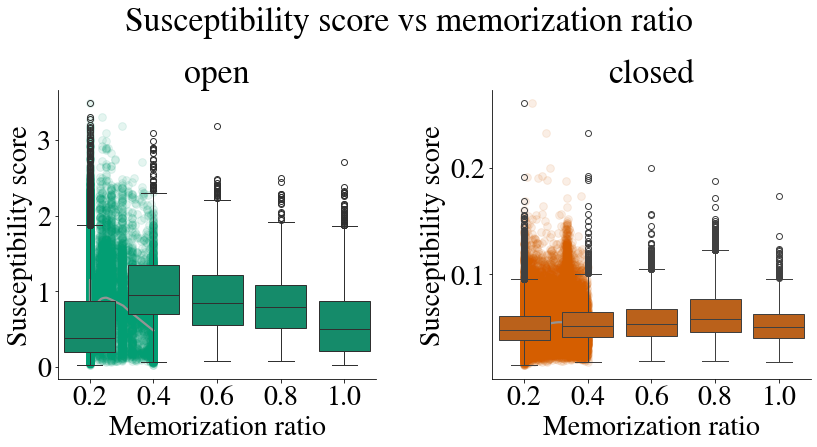

In [73]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 60, "alpha": 0.1}

qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
qid_df_mr_all = pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
qid_df_mr_all_grouped = (
    # qid_df_mr_all.groupby(["q_id", "query_form", "query_type"])
    # qid_df_mr_all.groupby(
    #     ["q_id", "query_form", "query_type", "type"]
    # )
    qid_df_mr_all.groupby(["q_id", "query_form", "query_type", "type", "entity"])
    .agg({"susceptibility_score": "mean", "sampled_mr": "mean"})
    .reset_index()
)
labels = [0.2, 0.4, 0.6, 0.8, 1.0]
qid_df_mr_all_grouped["mr_bin"] = pd.cut(
    qid_df_mr_all_grouped["sampled_mr"], 5, labels=labels
)

for i, qt in enumerate(
    sorted(qid_df_mr_all_grouped["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.regplot(
        data=qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)],
        x="sampled_mr",
        y="susceptibility_score",
        # hue="query_type",
        # legend=None,
        lowess=True,
        ax=ax,
        line_kws={"color": LINE_COLOR},
        scatter_kws={**scatter_kws, "color": colormap[qt]},
    )

    ax.set_title(qt)
    ax.set_xlabel("Memorization ratio")
    ax.set_ylabel("Susceptibility score")

fig.suptitle("Susceptibility score vs memorization ratio", y=0.92)
plt.tight_layout()
plot_name = "plot_susscore_vs_mr_open_closed_all_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


[0.7521311475409836, 0.11418032786885246, 0.05967213114754098, 0.047540983606557376, 0.026475409836065573]
[0.4458606557377049, 0.167827868852459, 0.15438524590163935, 0.13684426229508198, 0.09508196721311475]


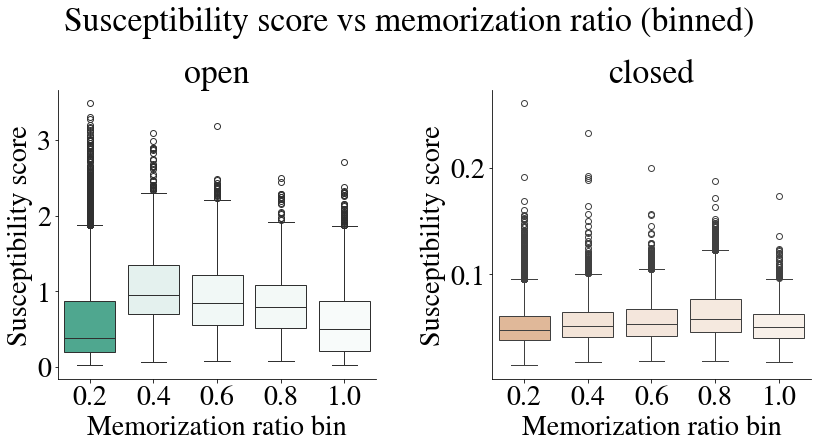

In [89]:
import matplotlib as mpl

# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

# labels = ["(0, 0.2]", "(0.2, 0.4]", "(0.4, 0.6]", "(0.6, 0.8]", "(0.8, 1.0]"]
labels = ["0.2", "0.4", "0.6", "0.8", "1.0"]
qid_df_mr_all_grouped["mr_bin"] = pd.cut(
    qid_df_mr_all_grouped["sampled_mr"], 5, labels=labels
)

for i, qt in enumerate(
    sorted(qid_df_mr_all_grouped["query_type"].unique(), reverse=True)
):

    ax = axes[i]
    sns.boxplot(
        data=qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)],
        x="mr_bin",
        y="susceptibility_score",
        ax=ax,
        color=colormap[qt],
    )
    count_per_bin = (
        qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)][
            "mr_bin"
        ].value_counts()
        / sum(
            qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)][
                "mr_bin"
            ].value_counts()
        )
    ).tolist()
    print(count_per_bin)
    for i, patch in enumerate(ax.patches):
        fc = patch.get_facecolor()
        patch.set_facecolor(mpl.colors.to_rgba(fc, count_per_bin[i]))
    # sns.regplot(
    #     data=qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)],
    #     x="sampled_mr",
    #     y="susceptibility_score",
    #     # hue="query_type",
    #     # legend=None,
    #     lowess=True,
    #     ax=ax,
    #     line_kws={"color": LINE_COLOR},
    #     scatter_kws={**scatter_kws, "color": colormap[qt]},
    # )
    ax.set_title(qt)
    ax.set_xlabel("Memorization ratio bin")
    # ax.tick_params(axis="x", which="major", labelsize="xx-small")
    ax.set_ylabel("Susceptibility score")

fig.suptitle("Susceptibility score vs memorization ratio (binned)", y=0.92)
plt.tight_layout()
plot_name = "plot_susscore_vs_mr_binned_open_closed_all_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

/cluster/home/kevidu/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


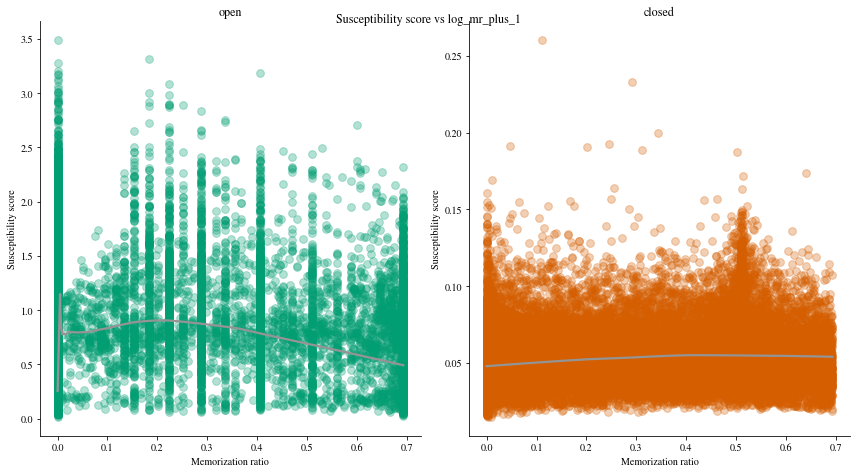

In [48]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 60, "alpha": 0.3}

qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
qid_df_mr_all = pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
qid_df_mr_all_grouped = (
    # qid_df_mr_all.groupby(["q_id", "query_form", "query_type"])
    # qid_df_mr_all.groupby(
    #     ["q_id", "query_form", "query_type", "type"]
    # )
    qid_df_mr_all.groupby(["q_id", "query_form", "query_type", "type", "entity"])
    .agg({"susceptibility_score": "mean", "sampled_mr": "mean"})
    .reset_index()
)
qid_df_mr_all_grouped["log_mr_plus_1"] = qid_df_mr_all_grouped["sampled_mr"].apply(
    lambda x: np.log(x + 1)
)
for i, qt in enumerate(
    sorted(qid_df_mr_all_grouped["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.regplot(
        data=qid_df_mr_all_grouped[(qid_df_mr_all_grouped["query_type"] == qt)],
        x="log_mr_plus_1",
        y="susceptibility_score",
        # hue="query_type",
        # legend=None,
        lowess=True,
        ax=ax,
        line_kws={"color": LINE_COLOR},
        scatter_kws={**scatter_kws, "color": colormap[qt]},
    )
    ax.set_title(qt)
    ax.set_xlabel("Memorization ratio")
    ax.set_ylabel("Susceptibility score")

fig.suptitle("Susceptibility score vs log_mr_plus_1", y=0.92)
plt.tight_layout()
plot_name = "plot_susscore_vs_mr_open_closed_all_queries"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path, bbox_inches="tight")
# wandb.log({plot_name: wandb.Image(fig)})

In [26]:
weird_closed_results = qid_df_mr_all_grouped[
    (qid_df_mr_all_grouped["query_type"] == "closed")
    & (qid_df_mr_all_grouped["sampled_mr"] > 0.5)
    & (qid_df_mr_all_grouped["susceptibility_score"] > 0.1)
]
weird_closed_results

,q_id,query_form,query_type,type,entity,susceptibility_score,sampled_mr,mr_bin
502,http://schema.org/actor,Q: Does '{entity}' feature {answer} as an acto...,closed,entities,"(American Pie 2,)",0.124307,0.514706,0.6
515,http://schema.org/actor,Q: Does '{entity}' feature {answer} as an acto...,closed,entities,"(Emmerdale,)",0.108122,0.502326,0.6
9745,http://schema.org/highestPoint,Q: Is {entity}'s highest point {answer}?\nA:,closed,entities,"(Uzbekistan,)",0.136146,0.844622,1.0
12404,http://schema.org/influencedBy,Q: Does {answer} influence {entity}?\nA:,closed,entities,"(Anton Chekhov,)",0.106859,0.713761,0.8
12411,http://schema.org/influencedBy,Q: Does {answer} influence {entity}?\nA:,closed,entities,"(Friedrich Engels,)",0.109570,0.630435,0.8
...,...,...,...,...,...,...,...,...
48195,reverse-http://yago-knowledge.org/resource/stu...,Q: Was a student of {entity} {answer}?\nA:,closed,gpt_fake_entities,"(Yasmine Daoudi,)",0.149839,0.669449,0.8
48196,reverse-http://yago-knowledge.org/resource/stu...,Q: Was a student of {entity} {answer}?\nA:,closed,gpt_fake_entities,"(Yelena Popova,)",0.114008,0.701169,0.8
48197,reverse-http://yago-knowledge.org/resource/stu...,Q: Was a student of {entity} {answer}?\nA:,closed,gpt_fake_entities,"(Yeong-ho Shin,)",0.105186,0.717863,0.8
48198,reverse-http://yago-knowledge.org/resource/stu...,Q: Was a student of {entity} {answer}?\nA:,closed,gpt_fake_entities,"(Zayd Bahar,)",0.118400,0.769616,0.8


In [27]:
weird_closed_results[["q_id", "type"]].value_counts().sort_index()

q_id                                                    type             
http://schema.org/actor                                 entities              2
http://schema.org/highestPoint                          entities              1
http://schema.org/influencedBy                          entities             27
                                                        gpt_fake_entities     3
http://schema.org/knowsLanguage                         entities              8
                                                        gpt_fake_entities    15
http://schema.org/locationCreated                       entities              1
http://schema.org/manufacturer                          entities              1
http://schema.org/nationality                           entities              3
                                                        gpt_fake_entities     2
http://schema.org/neighbors                             entities              1
                                              

In [28]:
weird_closed_results["q_id"].value_counts()

q_id
reverse-http://yago-knowledge.org/resource/studentOf      94
http://yago-knowledge.org/resource/studentOf              70
http://schema.org/performer                               59
reverse-http://yago-knowledge.org/resource/notableWork    50
http://schema.org/influencedBy                            30
reverse-http://schema.org/performer                       28
http://yago-knowledge.org/resource/notableWork            26
http://schema.org/knowsLanguage                           23
reverse-http://schema.org/sponsor                         11
reverse-http://schema.org/worksFor                        10
reverse-http://schema.org/memberOf                         6
reverse-http://yago-knowledge.org/resource/capital         6
http://schema.org/nationality                              5
reverse-http://schema.org/organizer                        5
http://schema.org/owns                                     4
reverse-http://schema.org/founder                          4
http://schema.org/n

### Comparison to MR - persuasion

Hypothesis: is the mean persuasion score for contexts where the model followed the context answer higher than the mean persuasion score for contexts where the model followed the OG answer?

$$H_0: \mathrm{mean}(\pi(x_c)) \leq \mathrm{mean}(\pi(x_o))$$
$$H_A: \mathrm{mean}(\pi(x_c)) > \mathrm{mean}(\pi(x_o))$$

where $x_c$ is the set of context-entity-pairs where the model chose to answer with the context-based answer and $x_o$ is the set of context-entity-pairs where the model chose to answer with the original memorized answer.

Given a query, we have $|C| \times |E|$ context-entity pairs (where $C$ is the set of contexts, $E$ is the set of entities). We partition this into group $\mathcal{C}$ (the contexts where the model chose to follow the context) and group $\mathcal{O}$ (the contexts where the model chose to follow the original memorized answer).

We run a permutation test for whether $\mathrm{mean}(\mathcal{C}) > \mathrm{mean}(\mathcal{O})$, for each of the queries.

In [29]:
val_df_per_qe = next(iter(qid_to_val_df_per_qe.items()))[1]

In [30]:
def explode_val_df_per_qe(val_df_per_qe):
    if isinstance(val_df_per_qe["sampled_answergroups"].iloc[0], str):
        val_df_per_qe["sampled_answergroups"] = val_df_per_qe[
            "sampled_answergroups"
        ].apply(literal_eval)

    val_df_per_qe["combined"] = val_df_per_qe.apply(
        lambda row: list(
            zip(
                row["contexts"],
                row["persuasion_scores_kl"],
                row["sampled_answergroups"],
            )
        ),
        axis=1,
    )
    exploded_df = pd.DataFrame(val_df_per_qe.explode("combined"))
    exploded_df[["context", "p_score", "sampled_answergroup"]] = pd.DataFrame(
        exploded_df["combined"].tolist(), index=exploded_df.index
    )
    exploded_df.drop(columns=["combined"], inplace=True)
    val_df_per_qe.drop(columns=["combined"], inplace=True)

    return exploded_df

In [31]:
set(qid_to_val_df_per_qe).difference(set(qid_to_dfs_with_mr))

set()

In [32]:
for qid, df in qid_to_dfs_with_mr.items():
    if isinstance(df["sampled_answergroups"].iloc[0], str):
        print(qid)
        df["sampled_answergroups"] = df["sampled_answergroups"].apply(literal_eval)
        qid_to_dfs_with_mr[qid] = df

In [33]:
# # Closed queries - plot persuasion scores vs sampled answer group for all queries
# qid_to_dfs_with_mr = dict(
#     sorted(
#         {
#             qid: df
#             for qid, df in qid_to_val_df_per_qe.items()
#             if "sampled_mr" in df.columns
#         }.items()
#     )
# )
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in tqdm(enumerate(qid_to_dfs_with_mr.items())):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "closed"]
#     exploded_df = explode_val_df_per_qe(qt_df)
#     ax = axes[row, col]
#     sns.violinplot(exploded_df, x="sampled_answergroup", y="p_score", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_pscore_vs_answergroup_closed_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.png")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

In [34]:
exploded_df_all = explode_val_df_per_qe(
    pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
)

In [35]:
qid_to_exploded_df = {
    qid: exploded_df_all[exploded_df_all["q_id"] == qid]
    for qid in tqdm(exploded_df_all["q_id"].unique())
}

100%|██████████| 122/122 [02:13<00:00,  1.09s/it]


In [57]:
from analysis_helpers import (
    compute_ttest_scores_dfs,
    count_num_significant_queries,
    compute_and_summarize_ttest_results,
)

In [55]:
qid_to_mean_exploded_df = {
    qid: (
        df.groupby(
            [
                "q_id",
                "query_form",
                "entity",
                "query_type",
                "sampled_answergroup",
            ]
        )
        .agg(mean_p_score=("p_score", "mean"))
        .reset_index()
    )
    for qid, df in qid_to_exploded_df.items()
}

In [65]:
compute_and_summarize_ttest_results(
    qid_to_mean_exploded_df,
    group1=0,
    group2=1,
    score_col="mean_p_score",
    type_col="sampled_answergroup",
    permutations=10000,
    alternative="less",
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


For query_id http://schema.org/actor, cohen_d=nan and cohen_d2=nan don't match.
For query_id http://schema.org/leader, cohen_d=nan and cohen_d2=nan don't match.


100%|██████████| 122/122 [00:14<00:00,  8.29it/s]


(                                                 query  effect_size  p_value  \
 0        http://yago-knowledge.org/resource/parentBody    -1.161388      0.0   
 1                             http://schema.org/spouse    -1.192030      0.0   
 2           http://yago-knowledge.org/resource/capital    -1.776394      0.0   
 3                               http://schema.org/isbn    -2.678416      0.0   
 4                       http://schema.org/influencedBy    -0.906629      0.0   
 ..                                                 ...          ...      ...   
 103              reverse-http://schema.org/parentTaxon     1.087788      1.0   
 104                   reverse-http://schema.org/editor     2.313257      1.0   
 105                       http://schema.org/deathPlace     0.814973      1.0   
 106                  http://schema.org/contentLocation     1.174730      1.0   
 107  http://yago-knowledge.org/resource/academicDegree     0.563518      1.0   
 
        n  bh_adj_p_value 

In [38]:
ttest_res_open_p_df, ttest_res_closed_p_df = compute_ttest_scores_dfs(
    qid_to_exploded_df,
    group1=0,
    group2=1,
    score_col="p_score",
    type_col="sampled_answergroup",
    permutations=5000,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


For query_id http://schema.org/actor, cohen_d=nan and cohen_d2=nan don't match.
For query_id http://schema.org/leader, cohen_d=nan and cohen_d2=nan don't match.


100%|██████████| 122/122 [58:39<00:00, 28.85s/it]


In [50]:
ttest_res_closed_p_df

,query,effect_size,p_value,n,bh_adj_p_value
0,http://schema.org/about,-0.100494,0.0,119611,0.0
1,http://schema.org/nationality,-0.057730,0.0,109921,0.0
2,http://schema.org/neighbors,-0.055221,0.0,119502,0.0
3,http://schema.org/numberOfEmployees,-0.159041,0.0,119458,0.0
4,http://schema.org/ownedBy,-0.073001,0.0,116072,0.0
...,...,...,...,...,...
117,http://yago-knowledge.org/resource/radialVelocity,0.050492,1.0,120000,1.0
118,http://schema.org/numberOfEpisodes,0.132609,1.0,118381,1.0
119,http://schema.org/dateCreated,0.074286,1.0,119644,1.0
120,http://schema.org/highestPoint,0.102810,1.0,119031,1.0


In [39]:
count_num_significant_queries(
    ttest_res_open_p_df, col_name="bh_adj_p_value", alpha=0.05, alternative="less"
)

{'count': {'significant (less)': 64, 'insignificant': 44},
 'proportion': {'significant (less)': 0.5925925925925926,
  'insignificant': 0.4074074074074074}}

In [40]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
        ttest_res_open_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "significant (less)": 64,
    "insignificant": 44
  },
  "proportion": {
    "significant (less)": 0.5925925925925926,
    "insignificant": 0.4074074074074074
  }
}


Closed:
{
  "count": {
    "significant (less)": 42,
    "insignificant": 80
  },
  "proportion": {
    "significant (less)": 0.3442622950819672,
    "insignificant": 0.6557377049180327
  }
}


In [41]:
exploded_df_all[
    (exploded_df_all["q_id"] == "http://schema.org/about")
    & (exploded_df_all["query_type"] == "open")
    & (exploded_df_all["sampled_answergroup"] == 1)
], exploded_df_all[
    (exploded_df_all["q_id"] == "http://schema.org/about")
    & (exploded_df_all["query_type"] == "open")
    & (exploded_df_all["sampled_answergroup"] == 0)
]

(                        q_id                        query_form  \
 243  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 300  http://schema.org/about               '{entity}' is about   
 301  http://schema.org/about               '{entity}' is about   
 301  http://schema.org/about               '{entity}' is about   
 302  http://schema.org/about               '{entity}' is about   
 ..                       ...                               ...   
 394  http://schema.org/about               '{entity}' is about   
 394  http://schema.org/about               '{entity}' is about   
 395  http://schema.org/about               '{entity}' is about   
 396  http://schema.org/about               '{entity}' is about   
 396  http://schema.org/about               '{entity}' is about   
 
                                      entity             answer  \
 243                         (Mrs. Miniver,)  Battle of Britain   
 300                 (Crime and Punishment,)            angu

In [42]:
mean_pscore_per_answergroup = (
    exploded_df_all.groupby(["q_id", "query_form", "query_type", "sampled_answergroup"])
    .agg({"p_score": "mean"})
    .reset_index()
)

In [43]:
from measuring.utils import AnswerGroup

In [44]:
answergroup_to_presentable = {
    AnswerGroup.ORIGINAL.value: "Original",
    AnswerGroup.CONTEXT.value: "Context",
    AnswerGroup.OTHER.value: "Other",
}
mean_pscore_per_answergroup["presentable_answergroup"] = mean_pscore_per_answergroup[
    "sampled_answergroup"
].apply(lambda x: answergroup_to_presentable[x])

In [45]:
mean_pscore_per_answergroup

,q_id,query_form,query_type,sampled_answergroup,p_score,presentable_answergroup
0,http://schema.org/about,'{entity}' is about,open,0,0.883970,Original
1,http://schema.org/about,'{entity}' is about,open,1,1.242628,Context
2,http://schema.org/about,'{entity}' is about,open,2,0.917874,Other
3,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,0,0.051875,Original
4,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,1,0.051362,Context
...,...,...,...,...,...,...
1353,reverse-http://yago-knowledge.org/resource/ter...,Q: What is {entity} the terminus of?\nA:,open,1,0.919905,Context
1354,reverse-http://yago-knowledge.org/resource/ter...,Q: What is {entity} the terminus of?\nA:,open,2,0.441290,Other
1355,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,open,0,1.908677,Original
1356,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,open,1,2.296814,Context


In [46]:
mean_pscore_per_answergroup[mean_pscore_per_answergroup["query_type"] == qt]

,q_id,query_form,query_type,sampled_answergroup,p_score,presentable_answergroup
3,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,0,0.051875,Original
4,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,1,0.051362,Context
5,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,2,0.046223,Other
6,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,closed,0,0.060129,Original
7,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,closed,1,0.059293,Context
...,...,...,...,...,...,...
1347,reverse-http://yago-knowledge.org/resource/ter...,Q: Is the terminus of {answer} {entity}?\nA:,closed,1,0.051577,Context
1348,reverse-http://yago-knowledge.org/resource/ter...,Q: Is the terminus of {answer} {entity}?\nA:,closed,2,0.047751,Other
1349,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,closed,0,0.049849,Original
1350,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,closed,1,0.048246,Context


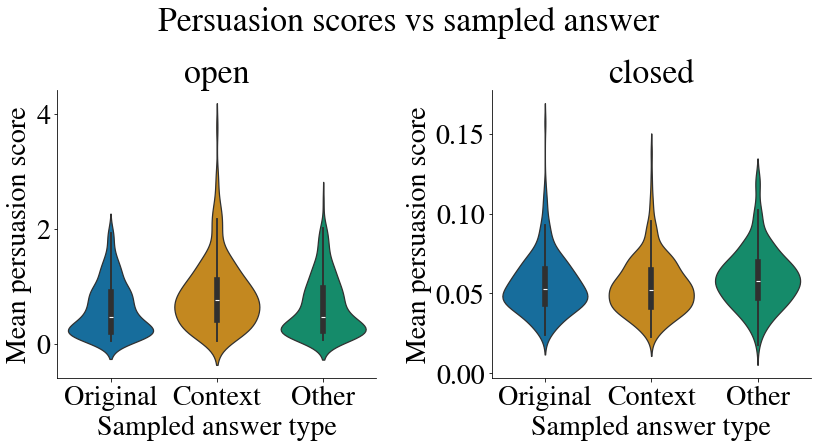

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(
    sorted(mean_pscore_per_answergroup["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.violinplot(
        data=mean_pscore_per_answergroup[
            mean_pscore_per_answergroup["query_type"] == qt
        ],
        x="presentable_answergroup",
        y="p_score",
        hue="presentable_answergroup",
        # size=10,
        # dodge=True,
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Sampled answer type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores vs sampled answer",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_sampled_answer_agg_ents_and_queries_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")